<div class="alert alert-info">
    <h1>Analysis of Saturn's F Ring During the Cassini Mission</h1>
    <h1>How Do Changes in Calibration and Image Processing Affect Results?</h1>
    
Robert S. French, rfrench@seti.org - Last updated April 8, 2024

Research performed under NASA Grant 80NSSC21K0527 for CDAP proposal "The Recent History of Saturn's Dusty Rings".

<h2>The Problem</h2>

<ol><li> French (2012) used inconsistently-calibrated images. Observations through ISS_041RF_FMOVIE001_VIMS
   used CISSCAL 3.3. Observations after that used CISSCAL 3.6. The current work uses CISSCAL 4.0beta (which is supposed to be identical to CISSCAL 4.0).</li>
   
<li>French (2012) used radial extents from 138,465-141,835. The current work uses 139,223-141,223.</li>

<li>French (2012) used old image processing software to take one radial slice per image. 
   <ul>
      <li>The slice was taken at the point of least ring curvature and covered an inconsistent amount of longitude.
           The EW for an entire observation was the mean (+/- std dev) of those radial slices.</li>
      <li>The normal EW was computed by applying a single mean emission angle to all radial slices in an observation.</li>
      <li>The current work uses image reprojection and mosaicing to create a rectangular grid of longitude/radius.
          This process could potentially introduce changes in photometry.</li>
      <li>Longitudes are sampled at intervals of 0.02 degrees. The EW for an entire observation is the mean
          (+/- std dev) of these radial slices.</li>
      <li>The normal EW is computed on a slice-by-slice basis by looking at the emission angle for that particular
          slice.</li>
      <li>There are many more radial slices than in French (2012), resulting in more thorough coverage of the
          variability of the ring.</li>
    </ul>
    </li>
    </ol>
    
<h2>Methodology</h2>

Compare French (2012) to Current Data
<ul>
    <li>Use the same 25 F ring observations used in 2012.</li>
    <li>Compare the EWs between French (2012) results and current results.</li>
    <li>Use individual images to check on calibration differences with different versions.</li>
    <li>Apply those differences to the data to see if changes in calibration totally account for measurement differences.</li>
</ul>
</div>

# Read Data and Initialize Data Structures

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..'); sys.path.append('../external')

from f_ring_util.f_ring import (add_cisscal_ratios,
                                add_hover,
                                find_common_data_2012,
                                read_ew_stats)

%matplotlib widget
mpl.rcParams['figure.max_open_warning'] = 100

In [2]:
# Read the new data and populate the old data
obsdata = read_ew_stats('../data_files/cass_ew_60_0.csv',
                        obslist_filename='CASSINI_OBSERVATION_LIST',
                        obslist_column='For Photometry')

# Find the intersection of the old and new data
# This also adds in the fields:
#   'EW Mean_2012', 'EW Std_2012': Actual measurements from French et al. (2012)
#   'Normal EW Mean_2012': 'EW Mean_2012' adjusted for current mean emission
#   'EW Mean Ratio': 'EW Mean' / 'EW Mean_2012'
#   'Normal EW Mean Ratio': 'Normal EW Mean' / 'Normal EW Mean_2012'
commondata = find_common_data_2012(obsdata)
# If there are any missing observation names, it is because they are marked with
# 'For Photometry'==False in the observation list.

# Add CISSCAL ratios
# This adds in the fields:
#    'CISSCAL Ratio': The ratio of CISSCAL 4.0 / CISSCAL 3.[36] taken from single sample images for each observation
#                     using the area +/- km around the F ring core
#    'Adjusted Normal EW Mean_2012': 'Normal EW Mean_2012' * 'CISSCAL Ratio'
commondata = add_cisscal_ratios(commondata)

** SUMMARY STATISTICS - ../data_files/cass_ew_60_0.csv **
Unique observation names: 157
Total slices: 157
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 16:31:39
Total number of new observation names: 157
Total number of observation names from 2012: 25
Number of observation names in common: 24
Missing observation names: {'ISS_007RI_LPHRLFMOV001_PRIME'}


# Compare [Old] French (2012) EWs with [New] Current EWs

In [3]:
# Extract measurements from each CISSCAL version range
commondata33 = commondata.loc[:'ISS_041RF_FMOVIE002_VIMS']
commondata36 = commondata.loc['ISS_044RF_FMOVIE001_VIMS':]
print('CISSCAL 3.6 starts at', commondata.loc['ISS_044RF_FMOVIE001_VIMS']['Date'])
print('Number of CISSCAL 3.3 observations:', len(commondata33))
print('Number of CISSCAL 3.6 observations:', len(commondata36))

CISSCAL 3.6 starts at 2007-05-05 04:51:11
Number of CISSCAL 3.3 observations: 13
Number of CISSCAL 3.6 observations: 11


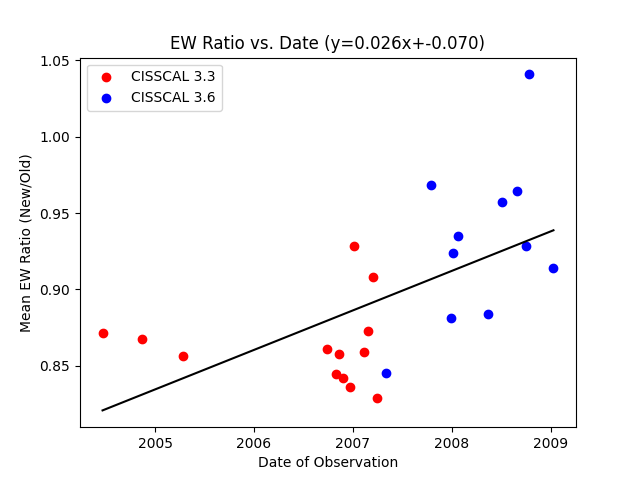

In [4]:
plt.figure()
coeff = np.polyfit(commondata['Date_days'], commondata['EW Mean Ratio'], 1)
date_min = commondata['Date_days'].min()
date_max = commondata['Date_days'].max()
plt.plot([date_min,date_max], np.polyval(coeff, [date_min,date_max]), '-',
         color='black')
p1 = plt.scatter(commondata33['Date'], commondata33['EW Mean Ratio'],
                 color='red', label='CISSCAL 3.3')
p2 = plt.scatter(commondata36['Date'], commondata36['EW Mean Ratio'],
                 color='blue', label='CISSCAL 3.6')
add_hover(commondata33, p1, commondata36, p2)
plt.legend(loc='upper left')
plt.xlabel('Date of Observation')
plt.ylabel('Mean EW Ratio (New/Old)')
_=plt.title(f'EW Ratio vs. Date (y={coeff[0]*365.25:.3f}x+{coeff[1]:.3f})')

In [5]:
print('How much was EW affected by CISSCAL version?')
c33_mean = commondata33['EW Mean Ratio'].mean()
c36_mean = commondata36['EW Mean Ratio'].mean()
overall_mean = commondata['EW Mean Ratio'].mean()
print(f'  CISSCAL 3.3 obs only - Mean New/Old EW: {c33_mean:.3f}')
print(f'  CISSCAL 3.6 obs only - Mean New/Old EW: {c36_mean:.3f}')
print(f'              All Data - Mean New/Old EW: {overall_mean:.3f}')

How much was EW affected by CISSCAL version?
  CISSCAL 3.3 obs only - Mean New/Old EW: 0.864
  CISSCAL 3.6 obs only - Mean New/Old EW: 0.931
              All Data - Mean New/Old EW: 0.895


<div class="alert alert-info">
<h2>Conclusion</h2>

<b>EWs based on images calibrated with CISSCAL 4.0 will appear ~10% *dimmer* than EWs based on previously calibrated images. Since we measured
a brightening in the F ring using previous versions of CISSCAL, that amount of brightening will now be less.
The difference in CISSCAL versions shows a distinct time dependence, with CISSCAL 3.3 being more distant from the new 4.0 and the more recent 3.6 converging on the new 4.0.</b>
</div>

# Compare Individual Images Calibrated with CISSCAL 3.3/3.6 to 4.0

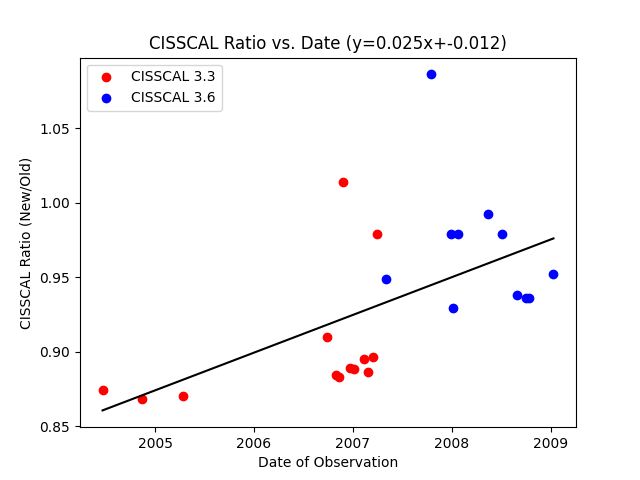

In [6]:
plt.figure()
coeff = np.polyfit(commondata['Date_days'], commondata['CISSCAL Ratio'], 1)
date_min = commondata['Date_days'].min()
date_max = commondata['Date_days'].max()
plt.plot([date_min,date_max], np.polyval(coeff, [date_min,date_max]), '-',
         color='black')
p1 = plt.scatter(commondata33['Date'], commondata33['CISSCAL Ratio'],
                 color='red', label='CISSCAL 3.3')
p2 = plt.scatter(commondata36['Date'], commondata36['CISSCAL Ratio'],
                 color='blue', label='CISSCAL 3.6')
add_hover(commondata33, p1, commondata36, p2)
plt.legend(loc='upper left')
plt.xlabel('Date of Observation')
plt.ylabel('CISSCAL Ratio (New/Old)')
_=plt.title(f'CISSCAL Ratio vs. Date (y={coeff[0]*365.25:.3f}x+{coeff[1]:.3f})')

In [7]:
print('How much was image calibration affected by CISSCAL version?')
c33_mean = commondata33['CISSCAL Ratio'].mean()
c36_mean = commondata36['CISSCAL Ratio'].mean()
overall_mean = commondata['CISSCAL Ratio'].mean()
print(f'  CISSCAL 3.3 obs only - Mean New/Old EW: {c33_mean:.3f}')
print(f'  CISSCAL 3.6 obs only - Mean New/Old EW: {c36_mean:.3f}')
print(f'              All Data - Mean New/Old EW: {overall_mean:.3f}')

How much was image calibration affected by CISSCAL version?
  CISSCAL 3.3 obs only - Mean New/Old EW: 0.903
  CISSCAL 3.6 obs only - Mean New/Old EW: 0.969
              All Data - Mean New/Old EW: 0.933


<div class="alert alert-info">
<h2>Conclusion</h2>
    
<b>The changes in CISSCAL when measured pixel-by-pixel on individual images show approximately the same time dependence as the changes in EW above. The ratio new/old based on images is a little closer to 1 than when based on EW profiles. This could be due to sampling error, since there are far more images being processed when using EW profiles. But regardless of the absolute values, the trend is still the same.</b>
</div>

# Compare 2012 EWs Adjusted for CISSCAL Ratios to Current EWs

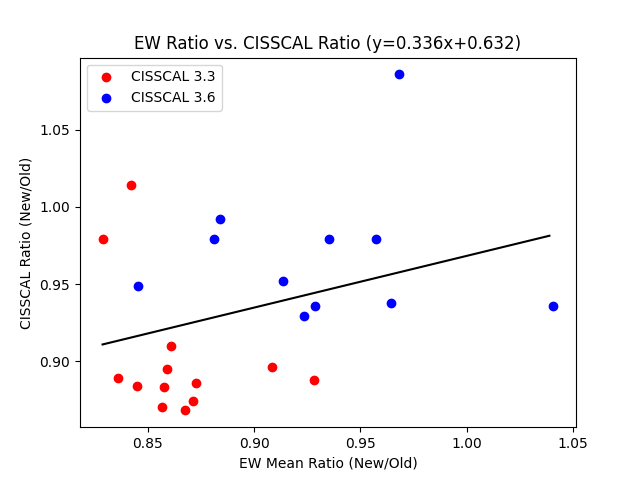

In [8]:
plt.figure()
coeff = np.polyfit(commondata['EW Mean Ratio'], commondata['CISSCAL Ratio'], 1)
ewr_min = commondata['EW Mean Ratio'].min()
ewr_max = commondata['EW Mean Ratio'].max()
p1 = plt.scatter(commondata33['EW Mean Ratio'], commondata33['CISSCAL Ratio'],
                 color='red', label='CISSCAL 3.3')
p2 = plt.scatter(commondata36['EW Mean Ratio'], commondata36['CISSCAL Ratio'],
                 color='blue', label='CISSCAL 3.6')
add_hover(commondata33, p1, commondata36, p2)
xrange = np.arange(ewr_min, ewr_max, 0.01)
plt.plot(xrange, np.polyval(coeff, xrange), '-', color='black')
plt.legend(loc='upper left')
plt.xlabel('EW Mean Ratio (New/Old)')
plt.ylabel('CISSCAL Ratio (New/Old)')
_=plt.title(f'EW Ratio vs. CISSCAL Ratio (y={coeff[0]:.3f}x+{coeff[1]:.3f})')

In [9]:
print('Answering the question: Does adjusting by the CISSCAL ratio fully account for the EW ratio?')
print('Looking at (EW_new / EW_2012) / (CISSCAL_new / CISSCAL_2012):')
cratio = (commondata['EW Mean Ratio']/commondata['CISSCAL Ratio']).mean()
cratio33 = (commondata33['EW Mean Ratio']/commondata33['CISSCAL Ratio']).mean()
cratio36 = (commondata36['EW Mean Ratio']/commondata36['CISSCAL Ratio']).mean()
print(f'  Mean all obs: {cratio:.3f}')
print(f'  Mean 3.3 obs: {cratio33:.3f}')
print(f'  Mean 3.6 obs: {cratio36:.3f}')

Answering the question: Does adjusting by the CISSCAL ratio fully account for the EW ratio?
Looking at (EW_new / EW_2012) / (CISSCAL_new / CISSCAL_2012):
  Mean all obs: 0.961
  Mean 3.3 obs: 0.960
  Mean 3.6 obs: 0.963


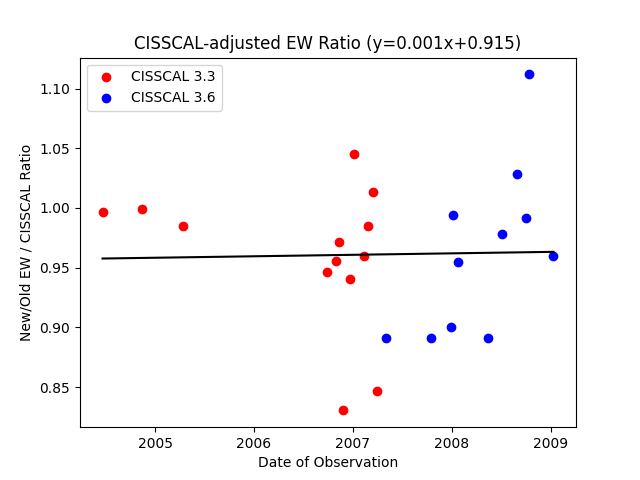

In [10]:
plt.figure()
coeff = np.polyfit(commondata['Date_days'],
                   commondata['EW Mean Ratio'] / commondata['CISSCAL Ratio'], 1)
date_min = commondata['Date_days'].min()
date_max = commondata['Date_days'].max()
p1 = plt.scatter(commondata33['Date'], commondata33['EW Mean Ratio'] / commondata33['CISSCAL Ratio'],
                 color='red', label='CISSCAL 3.3')
p2 = plt.scatter(commondata36['Date'], commondata36['EW Mean Ratio'] / commondata36['CISSCAL Ratio'],
                 color='blue', label='CISSCAL 3.6')
add_hover(commondata33, p1, commondata36, p2)
plt.plot([date_min,date_max], np.polyval(coeff, [date_min,date_max]), '-',
         color='black')
plt.legend()
plt.xlabel('Date of Observation')
plt.ylabel('New/Old EW / CISSCAL Ratio')
_=plt.title(f'CISSCAL-adjusted EW Ratio (y={coeff[0]*365.25:.3f}x+{coeff[1]:.3f})')

<div class="alert alert-info">
<h2>Conclusion</h2>
    
<b>EW Ratio and CISSCAL Ratio are clearly correlated, as you would expect if the CISSCAL change was the primary
    driver of the EW change.</b>
<p>
<b>Adjusting for changes in CISSCAL ratio accounts for all but ~4% of the difference between 2012 and current
    EW data. This means that the changes in radial extent and reprojection/mosaicing should only account for a 4%
    difference, which is negligible.</b>
</div>